## Data Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from deepar_model_utils import prep_station_data
from deepar_model_utils import get_station_data
from deepar_model_utils import organize_station_data

%matplotlib inline

In [ ]:
#bucket = ""

In [ ]:
#file = "cleaned_historical_trips_2015_2022.csv"

#s3_data_location = f"s3://{bucket}/{file}*"
#trips = pd.read_csv(s3_data_location, parse_dates = True)

In [ ]:
#trips = trips[(trips["starttime"] > "2017-09-01") & (trips["stoptime"] < "2022-08-31")]

In [ ]:
#trips_start = trips[["starttime", "start station id", "start station name"]]
#trips_stop = trips[["stoptime", "end station id", "end station name"]]

In [ ]:
#trips_start.to_csv("model_trips_start_station_2017_2022.csv")
#trips_stop.to_csv("model_trips_stop_station_2017_2022.csv")

### Trip Start Station

Aka how many bikes left a station.

In [2]:
start_file = "model_trips_start_station_2017_2022.csv"

#s3_start_location = f"s3://{bucket}/{start_file}*"
#trips_start = pd.read_csv(s3_start_location, parse_dates = True)

trips_start = pd.read_csv(start_file, parse_dates = True)
trips_start.shape

(12072690, 4)

Check start station id matches up with start station name. In this case, some stations have changed names due to location changes or due to a lack of data standardization. `trips_start_lookup` is a lookup table to match between the different station ids and station names.

In [ ]:
#trips_start["start station id"].nunique()

In [ ]:
#trips_start["start station name"].nunique()

In [ ]:
#trips_start.drop_duplicates(subset = ["start station id", "start station name"]).to_csv("unique_start.csv")

In [ ]:
#trips_start_lookup = trips_start.drop(["Unnamed: 0", "starttime"], axis = 1).drop_duplicates()

In [ ]:
#trips_start_lookup.to_csv("trip_start_station_id_lookup.csv", index = False)

Will use start station id and not start station name. From manually looking at the data, station name has more variation and very similar station names have the same station id.

Although not terribly useful now, grouping by and getting the size will help with the resampling later.

In [3]:
trips_start_group = prep_station_data(trips_start, "start station id", "starttime")
sum(trips_start_group["size"])

/home/studio-lab-user/capstone_bikeshare/models/deepar/deepar_model_utils.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_clean[station_time] = pd.to_datetime(trips_clean[station_time])


12072690

Transform data into the format required by DeepAR. Not all series start at the same time or end at the same time. DeepAR allows series to start at different times, but I assume that all series have to end at the same time (or else how is prediction supposed to happen?).

The series is also grouped into 15-minute increments.

In [4]:
freq = "15min" # group and sum trips by a set increment
max_date = "2022-08-31 23:45:00" # make sure all series end at the same time

In [5]:
comp_station_dict = organize_station_data(trips_start_group, "start station id", "starttime", freq, max_date)

100%|██████████| 501/501 [00:22<00:00, 21.99it/s]


In [6]:
len(comp_station_dict)

501

In [7]:
trip_total = 0
for station in comp_station_dict:
    trip_total += sum(comp_station_dict[station]["target"])
    
trip_total

12072690

In [8]:
comp_station_list = [comp_station_dict[station] for station in comp_station_dict]

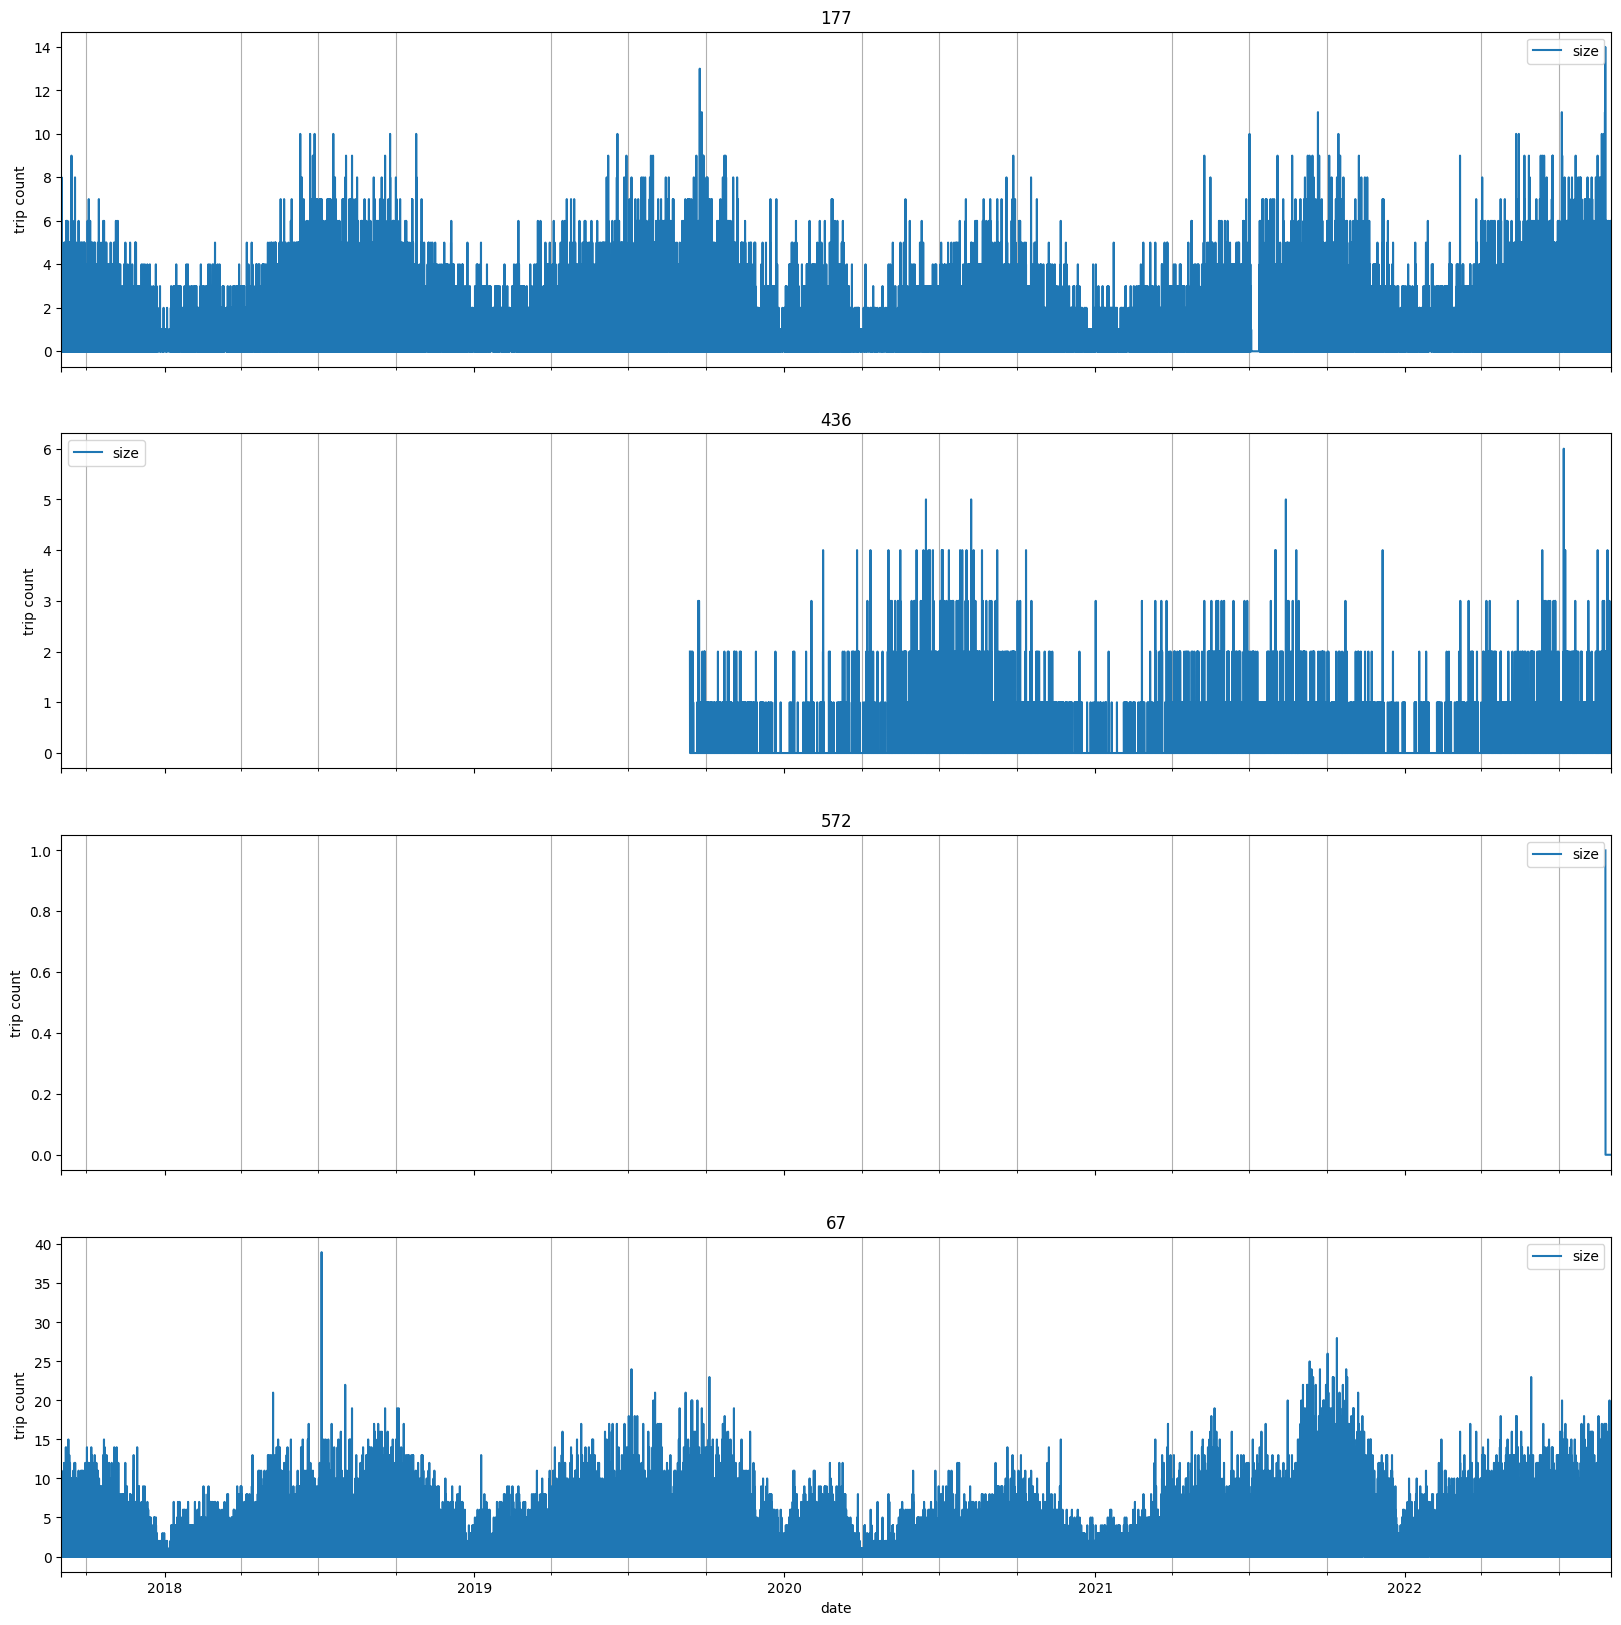

In [9]:
fig, axs = plt.subplots(4, 1, figsize = (20, 20), sharex = True)
axx = axs.ravel()
for i in range(0, 4):
    temp_station = [177, 436, 572, 67][i]
    get_station_data(trips_start_group, "start station id", "starttime", temp_station, freq, max_date).plot(ax = axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("trip count")
    axx[i].set_title(str(temp_station))
    axx[i].grid(which = "minor", axis = "x")

### Trip End Station

In [ ]:
end_file = "model_trips_stop_station_2017_2022.csv"

s3_end_location = f"s3://{bucket}/{end_file}*"
trips_stop = pd.read_csv(s3_end_location, parse_dates = True)